<h1>Content</h1>

1. Research data from files
2. Data preparation
    * 2.1. Adjustment of column names
    * 2.2. Processing NaNs
    * 2.3. Checking for duplicates
3. Exploratory data analysis
4. Segmentation & users' description
5. Tests of hypotheses
6. Conclusions & recommendations

<h1>Dashboard & Presentation</h1>

You can find the dashboard to this research via the link: <br>https://public.tableau.com/app/profile/svetlana6178/viz/Metanprombank_16472641453930/Dashboard?publish=yes

A presentation was also made for this research. It presents the patterns found in the data, provides some graphs and reflects recommendations for working with clients. The presentation can be found in the same folder next to the ipynb-file.

# Segmentation of "Metanprombank" customers by consumption

In this project, bank customers are analyzed and segmented according to the number of products consumed. Next, hypotheses about the difference in income between those customers who use two bank products and those who use one are tested. The hypothesis about the difference in the average income between residents of different cities is also tested.

**Data description:**

- userid — customer's id,
- score — credit scores,
- City — city of user's residence,
- Gender — gender,
- Age — age,
- Objects — number of objects in the property,
- Balance — account balance,
- Products — number of products used by the customer,
- CreditCard — has a customer got a credit card or not (0 - has not got, 1 - has got),
- Loyalty — is a customer active client or not (0 - inactive, 1 - active),
- estimated_salary — customer's salary,
- Churn — churn sign (0 - a customer has stayed, 1 - a customer has left).

## Research data from files

Import libraries and install settings:

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_palette('Set2')

Reading a data file, viewing dataframe information, and displaying a few lines on the screen:

In [2]:
bank = pd.read_csv('D:\\Work\\Яндекс-практикум\\Курс 13. Выпускной проект\\bank_dataset.csv')
bank.info()
bank.sample(n=5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9953,15698688,550,Ярославль,М,47,2,NaN,2,1,1,97057.280,0
3850,15818029,680,Ярославль,М,34,3,143292.950,1,1,0,66526.010,0
4962,15707824,531,Ярославль,Ж,42,2,NaN,2,0,1,90537.470,0
3886,15763677,710,Ростов Великий,М,34,8,147833.300,2,0,1,1561.580,0
5437,15776212,543,Ростов Великий,М,30,6,73481.050,1,1,1,176692.650,0


Numeric description of the columns:

In [3]:
bank[['score', 'Age', 'Objects', 'Products', 'CreditCard', 'Loyalty', 'estimated_salary', 'Churn']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Objects,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Products,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
CreditCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
Loyalty,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
estimated_salary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Churn,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


From the output, you can see that the `Balance` column contains gaps; data types correspond to the information they contain.

**Conclusion**

Preliminary analysis of the data showed that before conducting the data research, it is necessary to process the gaps, reduce the names of the columns to lower case, and also check the data for duplicates.

## Data preparation

### Adjustment of column names

As can be seen from the description of the data, the column names are quite informative, but for the convenience of further analysis, they must be reduced to lower case.

In [4]:
bank.columns = bank.columns.str.lower()
bank.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Processing NaNs

Let's display the number of gaps for all columns of our dataframe on the screen:

In [5]:
bank.isnull().sum()

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Let's see how many products have customers whose account balance is missing.

In [6]:
bank[bank['balance'].isnull() == True]['products'].value_counts()

2    2600
1     905
3      98
4      14
Name: products, dtype: int64

Большинство клиентов с отсутствующим значением в поле `balance` имеют 2 продукта, клиентов с 1 продуктом в 2.8 раз меньше, суммарное число остальных - 112. Возможно, остатки по счетам отсутствуют у тех, кто перестал быть клиентом банка. Проверим то предположение - выведем на экран такую же информацию, но в разрезе оттока.

Most of the clients with a missing value in the field `balance` have 2 products. There are in 2.8 times less clients with 1 product, the total number of the rest is 112. Those who have stopped to be a bank client may have no account balances. Let's check that assumption - we will display the same information on the screen, but in the context of the churn.

In [7]:
bank[bank['balance'].isnull() == True]['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

We see that our assumption was not confirmed, the part of churn among customers with missing balance values is small, only 14%, which is less than the average for the entire sample. Let's look at the distribution of salary of these clients.

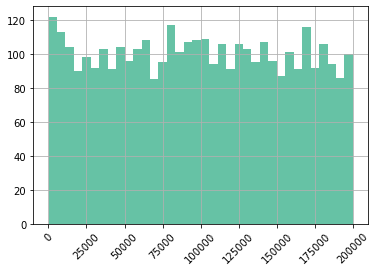

In [8]:
bank[bank['balance'].isnull() == True]['estimated_salary'].hist(bins=36)
plt.xticks(rotation=45)
plt.show()

Let's display the maximum value for the `estimated_salary` column:

In [9]:
bank['estimated_salary'].max()

199992.48

The histogram shows that the salaries of clients with missing values in the `balance` column are very diverse, and do not tend to any one value or range of values. Let's take a look at the credit card attribute column and see how many customers have it:

In [10]:
bank[bank['balance'].isnull() == True]['creditcard'].value_counts()

1    2592
0    1025
Name: creditcard, dtype: int64

About 70% of customers have a credit card, the percentage is the same as in the whole sample. Let's see what is the percentage of active clients in rows with gaps:

In [11]:
bank[bank['balance'].isnull() == True]['loyalty'].value_counts()

1    1873
0    1744
Name: loyalty, dtype: int64

The number of active and inactive clients are approximately equal - this indicator is also comparable with the indicator for the entire dataframe. Let's look at the data in the context of the city:

In [12]:
bank[bank['balance'].isnull() == True]['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

Clients with missing `balance` values reside only in Yaroslavl and Rybinsk. There are no such clients in Rostov Veliky. Let's print the results for the remaining fields - `gender`, `objects`, `age`.

In [13]:
bank[bank['balance'].isnull() == True]['gender'].value_counts()

М    1963
Ж    1654
Name: gender, dtype: int64

In [14]:
bank[bank['balance'].isnull() == True]['objects'].value_counts()

7     386
2     382
5     374
4     369
6     367
8     363
9     360
3     352
1     349
10    178
0     137
Name: objects, dtype: int64

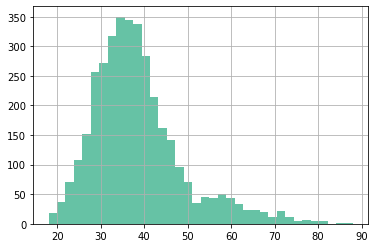

In [15]:
bank[bank['balance'].isnull() == True]['age'].hist(bins=36)
plt.show()

We see that there are no anomalies in the fields `gender`, `objects`, `age` for clients with gaps in the account balance. Let's display a numerical description of the features of such clients and compare it with the numerical description of the features for the entire sample, which has been printed on the first step of this project.

In [16]:
bank[bank['balance'].isnull() == True][['score', 'age', 'objects',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,3617.000,649.453,96.159,350.000,583.000,651.000,717.000,850.000
age,3617.000,38.435,10.492,18.000,31.000,37.000,43.000,88.000
objects,3617.000,5.071,2.861,0.000,3.000,5.000,7.000,10.000
products,3617.000,1.785,0.496,1.000,1.000,2.000,2.000,4.000
creditcard,3617.000,0.717,0.451,0.000,0.000,1.000,1.000,1.000
loyalty,3617.000,0.518,0.500,0.000,0.000,1.000,1.000,1.000
estimated_salary,3617.000,98983.560,57730.829,90.070,49506.820,98618.790,148330.970,199992.480
churn,3617.000,0.138,0.345,0.000,0.000,0.000,0.000,1.000


Almost all scores for the missing sample are very close to those for the total sample. Only the churn parameter in the sample with gaps is noticeably lower. Above we saw that clients from Rostov Veliky do not have gaps in the `balance` field. These results suggest that the gaps in the `balance` column are most likely due to the fact that a customer does not have an account or a debit card in the bank. Perhaps such customers simply use other banking services without opening an account (for example, loans, renting a safe deposit box, etc.), or the customer might close an existing card, and the value from the balance field was deleted. This gives us the right to fill in the gaps with zeros. But first, let's see if there are customers with a zero account balance.

In [17]:
print('Number of clients with zero account balance:', bank[bank['balance'] == 0]['balance'].count())

Number of clients with zero account balance: 0


There are no clients with an open account with a zero balance. Therefore, we can replace all missing values with `0`.

In [18]:
bank['balance'] = bank['balance'].fillna(0)

Let's check if all NaNs are processed:

In [19]:
bank.isnull().sum()

userid              0
score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
creditcard          0
loyalty             0
estimated_salary    0
churn               0
dtype: int64

We see that now there are no gaps.

### Checking for duplicates

Check the data for duplicates:

In [20]:
print('Number of duplicates in dataframe:', bank.duplicated().sum())

Number of duplicates in dataframe: 0


**Conclusion**

By converting the column names to lowercase, processing the gaps, and checking the dataframe for duplicates, we prepared the data for further research and work.

## Exploratory data analysis

Numeric description of the columns:

In [21]:
bank[['score', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
objects,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
products,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
creditcard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
loyalty,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
estimated_salary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
churn,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


From the numerical description of the columns, the following conclusions can be drawn:
- in the columns `score`, `objects`,`age` and `estimated_salary` the average values are almost equal to the median, which makes it possible to assume that there are no too big or too small values, which have effect on the overall picture;
- the average value of the balance field for `balance` is less than the median, which means that there is a noticeable amount of too small values in the sample (most likely, this is the influence of zeros, with which we filled in the gaps in the previous step);
- The average of `products` customer is 1.53, indicating that most customers use one or two products. This hypothesis is confirmed by the values of the second and third quartiles;
- the second quartile of the column `loyalty` is 0, and the third is 1, and the average value is 0.52, therefore the number of active and inactive bank users are equal;
- from the `creditcard` column, we can conclude that 70% of customers have credit cards, and from `churn` - that only about 20% of customers went to the churn.

Let's construct distributions:

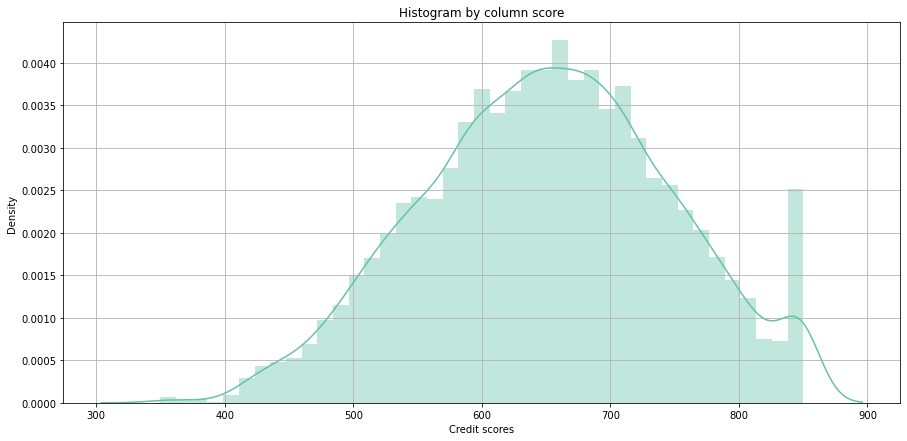

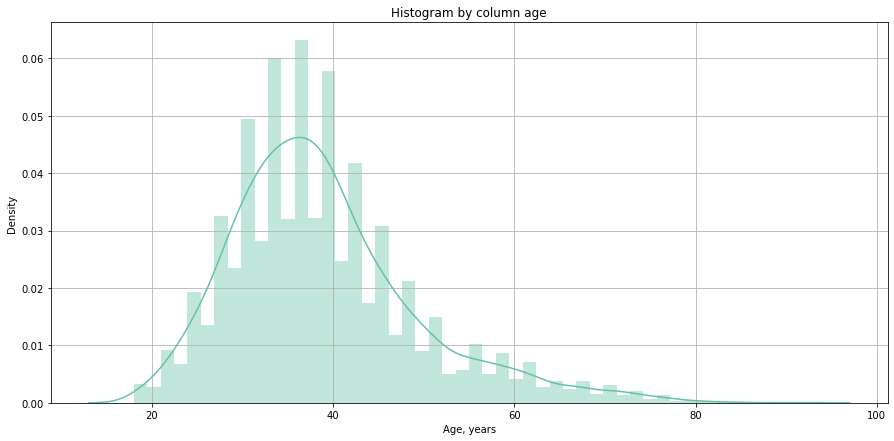

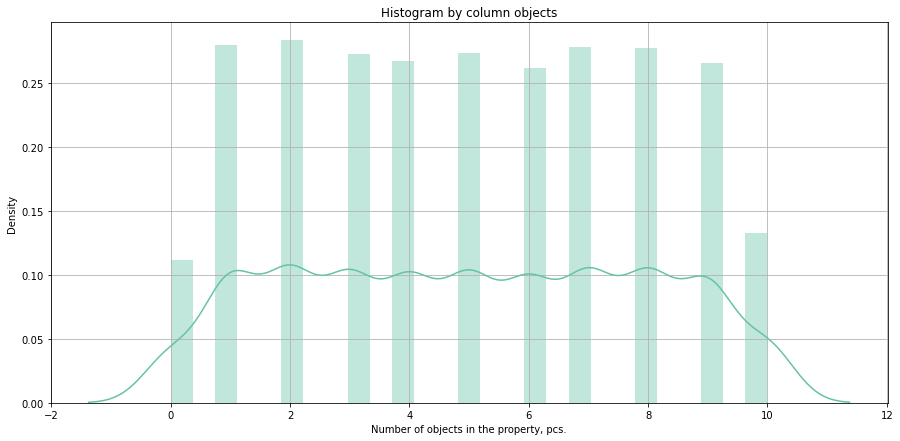

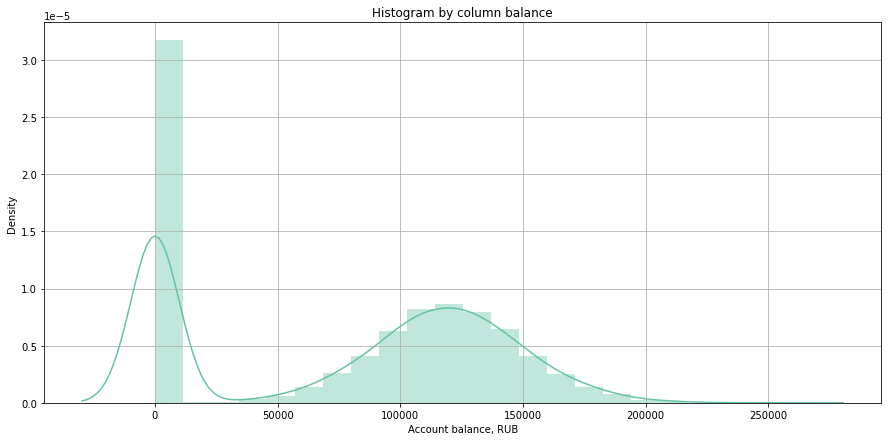

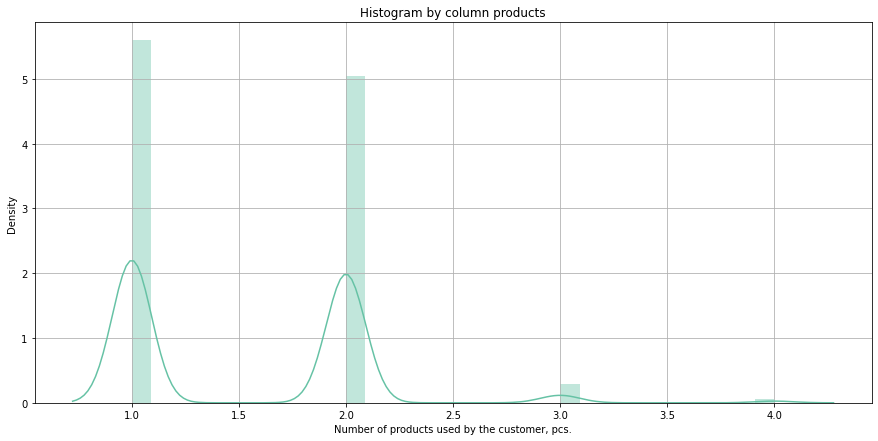

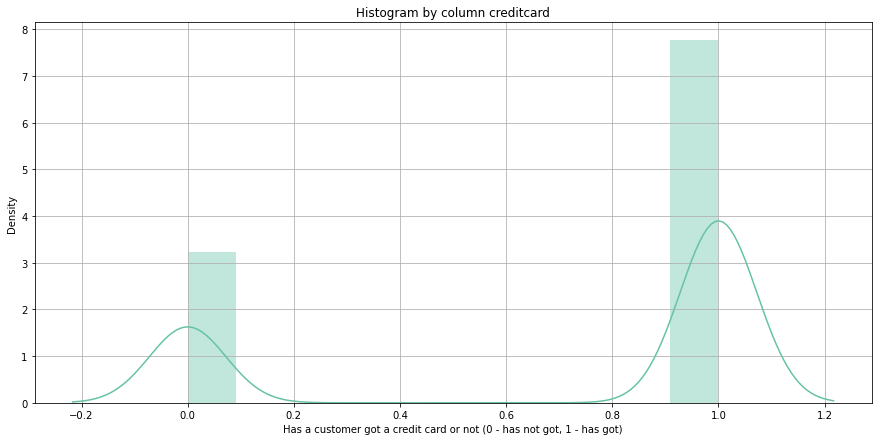

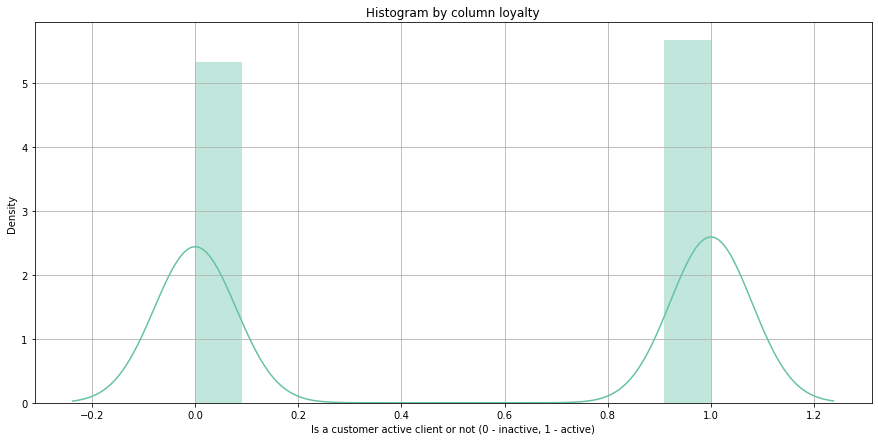

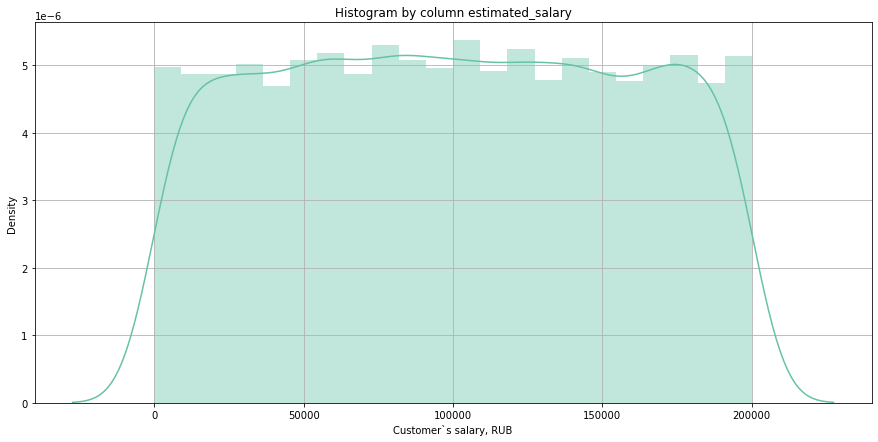

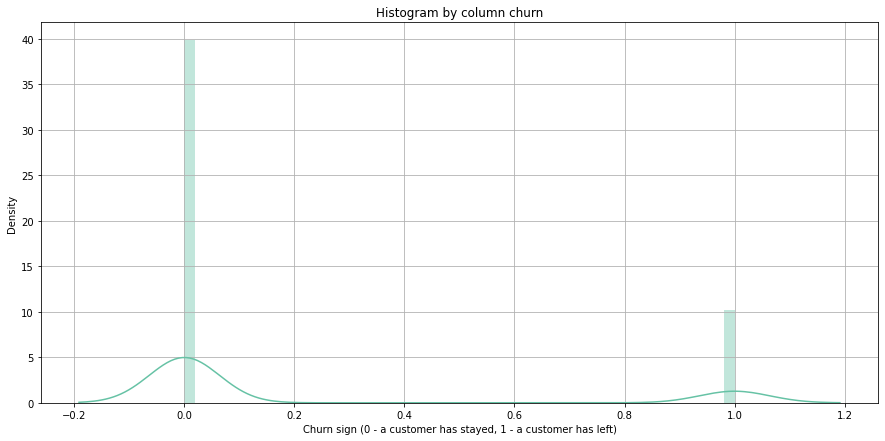

In [22]:
dict_of_col = {'score': 'Credit scores',
               'age': 'Age, years',
               'objects': 'Number of objects in the property, pcs.',
               'balance': 'Account balance, RUB',
               'products': 'Number of products used by the customer, pcs.',
               'creditcard': 'Has a customer got a credit card or not (0 - has not got, 1 - has got)',
               'loyalty': 'Is a customer active client or not (0 - inactive, 1 - active)',
               'estimated_salary': 'Customer`s salary, RUB',
               'churn': 'Churn sign (0 - a customer has stayed, 1 - a customer has left)'
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(15, 7))
    ax = sns.distplot(bank[col])
    ax.set_title('Histogram by column ' + col)
    ax.set_xlabel(dict_of_col[col])
    plt.grid()
    plt.show()

In general, the histograms confirmed the assumptions that were formulated during the analysis of the numerical description of the columns. However, here are some interesting observations to make:
- a peak is visible at the value of maximum credit rating;
- the number of clients with from 1 to 9 objects in the property is approximately the same. Those who have no objects and those who have 10 are noticeably fewer;
- outliers near zero are clearly visible in the `balance` column;
- number of people with different levels of salary in the sample are approximately equal.

Let's see how users are distributed by gender and by city:

In [23]:
(bank
 .groupby('gender')
 .agg({'userid': 'nunique'})
 .reset_index()
 .rename(columns={'userid': 'qty'})
)

,gender,qty
0,Ж,4543
1,М,5457


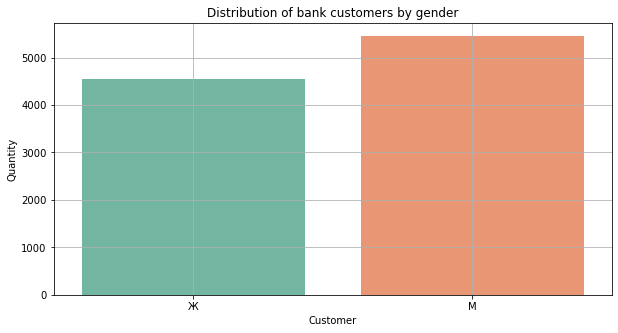

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='gender', y='userid', data=bank.groupby('gender').agg({'userid': 'nunique'}).reset_index())
ax.set_title('Distribution of bank customers by gender')
ax.set_xlabel('Customer')
ax.set_ylabel('Quantity')
plt.grid()
plt.show()

There are 16% more men (М) in the sample than women (Ж).

In [25]:
(bank
 .groupby('city')
 .agg({'userid': 'nunique'})
 .reset_index()
 .rename(columns={'userid': 'qty'})
)

,city,qty
0,Ростов Великий,2509
1,Рыбинск,2477
2,Ярославль,5014


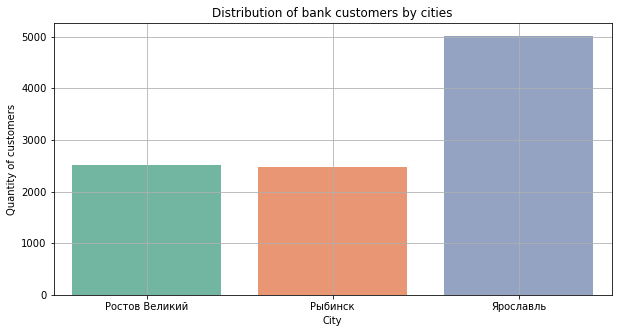

In [26]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='city', y='userid', data=bank.groupby('city').agg({'userid': 'nunique'}).reset_index())
ax.set_title('Distribution of bank customers by cities')
ax.set_xlabel('City')
ax.set_ylabel('Quantity of customers')
plt.grid()
plt.show()

Most of all among the bank's clients are residents of Yaroslavl. The inhabitants of Rostov Veliky and Rybinsk are approximately equal, and the number of inhabitants of each of them separately is approximately in 2 times less than that of Yaroslavl.

To complete the picture, we will construct boxplots for all features:

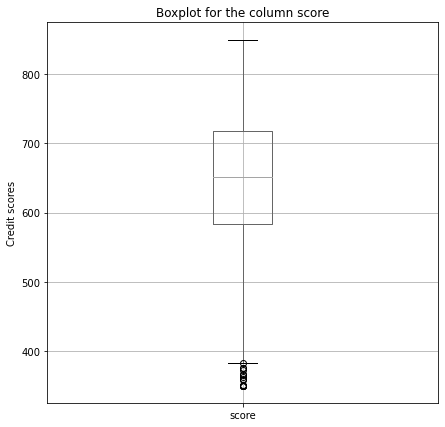

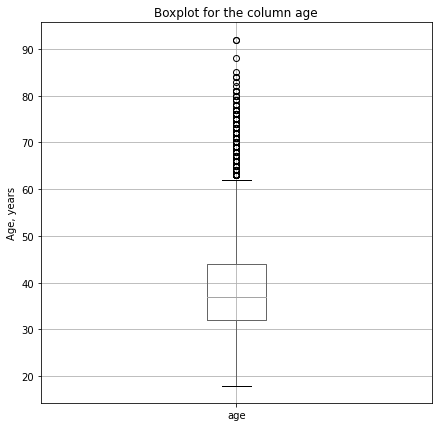

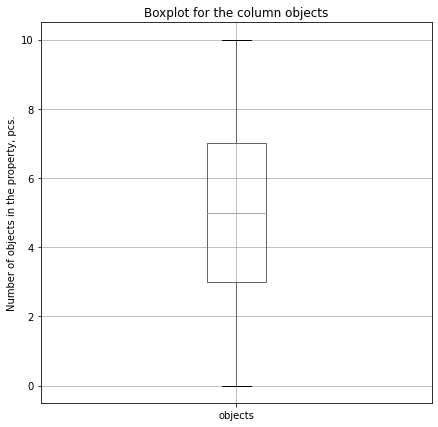

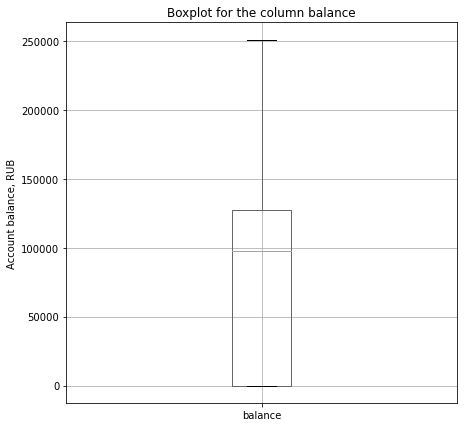

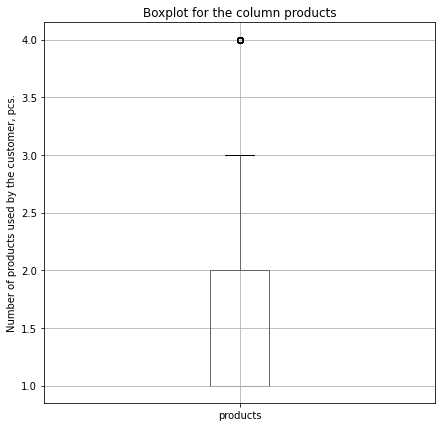

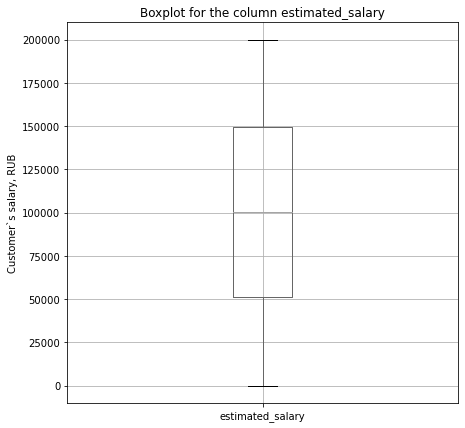

In [27]:
dict_of_col = {'score': 'Credit scores',
               'age': 'Age, years',
               'objects': 'Number of objects in the property, pcs.',
               'balance': 'Account balance, RUB',
               'products': 'Number of products used by the customer, pcs.',
               'estimated_salary': 'Customer`s salary, RUB',
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(7, 7))
    ax = bank[[col]].boxplot()
    ax.set_title('Boxplot for the column ' + col)
    ax.set_ylabel(dict_of_col[col])
    plt.show()

Outliers in credit scores lie at small values below 400. Most of the bank's clients are under 62 years old, clients older than this age are much less common. There are very few clients in the sample who use 4 banking products. The boxplot for `objects` shows that there are no outliers in the values of this parameter, the same applies to the `estimated_salary` and `balance` fields.

**Conclusion**

During the exploratory data analysis, the following conclusions were drawn:
- Most customers use one or two products;
- There are 16% more men in the sample than women;
- The largest number of bank users live in Yaroslavl, customers from Rostov the Great are approximately two times less than from Yaroslavl, as well as customers from Rybinsk;
- Active and inactive clients are approximately equal in the sample;
- There are outliers in the `balance` column with the value `0` - these values correspond to clients who do not have an account;
- About 70% of clients use credit cards;
- Approximately 20% of customers churned.

## Segmentation & users' description

Let's analyze the relationship between the number of products a client uses and each of the parameters: age, credit scoring, number of properties owned, balance, whether there is a credit card, a sign of activity, wages and churn. We will build graphs and calculate the average parameters for clients with a different number of banking products.

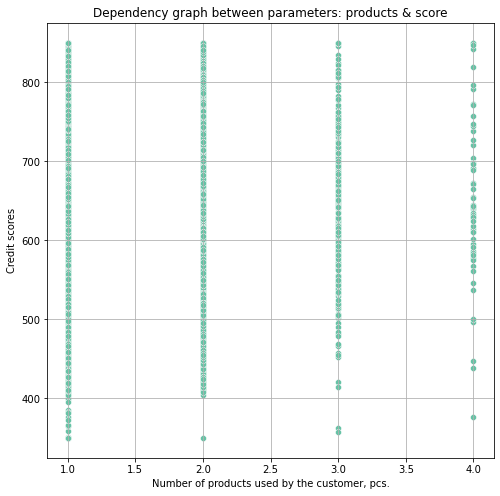

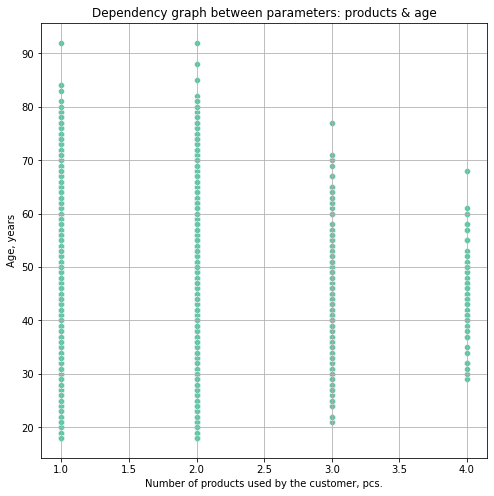

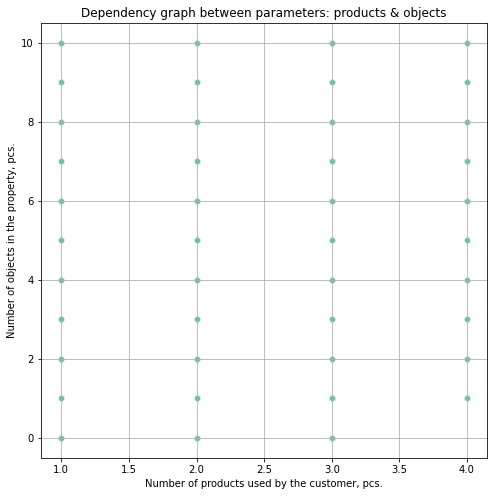

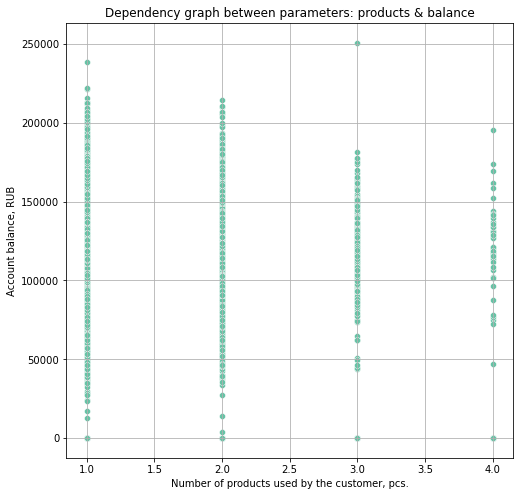

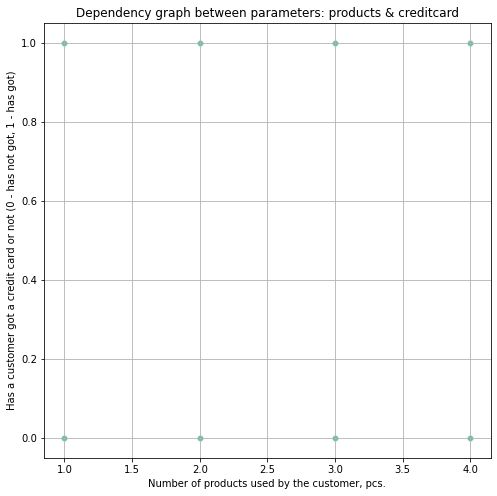

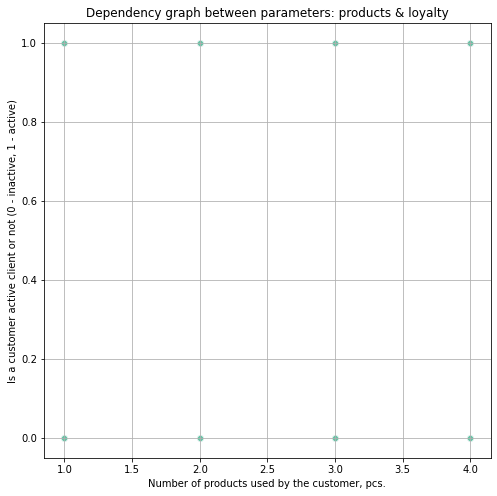

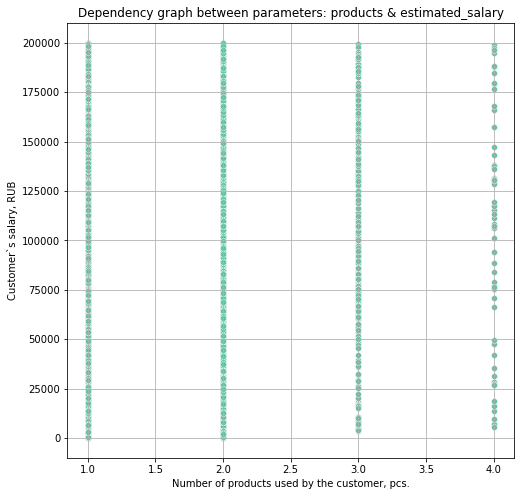

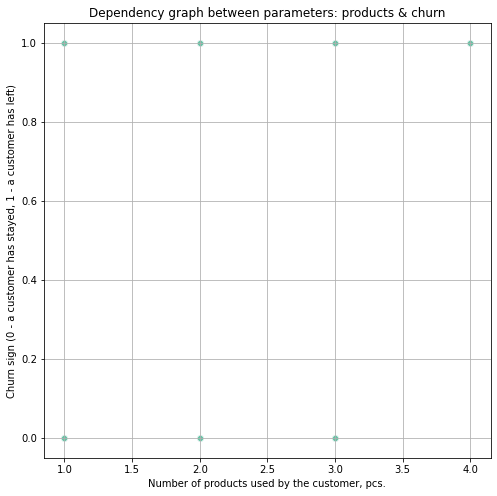

In [28]:
dict_of_col = {'score': 'Credit scores',
               'age': 'Age, years',
               'objects': 'Number of objects in the property, pcs.',
               'balance': 'Account balance, RUB',
               'creditcard': 'Has a customer got a credit card or not (0 - has not got, 1 - has got)',
               'loyalty': 'Is a customer active client or not (0 - inactive, 1 - active)',
               'estimated_salary': 'Customer`s salary, RUB',
               'churn': 'Churn sign (0 - a customer has stayed, 1 - a customer has left)'
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(data=bank, x="products", y=col)
    ax.set_title('Dependency graph between parameters: products & ' + col)
    ax.set_xlabel('Number of products used by the customer, pcs.')
    ax.set_ylabel(dict_of_col[col])
    plt.grid()
    plt.show()

Let's print the average values of the features for customers with a different number of banking products:

In [29]:
bank[['score', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].groupby('products').mean().T

products,1,2,3,4
score,649.121,652.189,648.105,653.583
age,39.673,37.754,43.195,45.683
objects,4.975,5.052,5.004,5.300
balance,98551.871,51879.146,75458.328,93733.135
creditcard,0.704,0.707,0.714,0.683
loyalty,0.504,0.533,0.425,0.483
estimated_salary,99487.257,100452.013,104318.131,104763.723
churn,0.277,0.076,0.827,1.000


From the graphs, correlation values and information printed above, the following patterns are visible:
- customers with 1 and 2 products are younger than customers with 3 and 4 products;
- the lowest credit rating for customers with 3 products, and the highest for customers with 4 products;
- customers with 1 and 2 products are more active than customers with 3 and 4;
- customers with 3 and 4 products have a higher salary, but also churn much more often;
- the largest number of properties owned by customers with 4 products on average;
- the smallest account balance for customers with 2 products, and the highest for users with 1 product.

As we can see, many of the metrics for customers with 3 and 4 products are similar. In addition, there are about the same number of customers with 1 and 2 products, and there are significantly fewer customers with 3 or more products. Therefore, we segment customers by the number of products they use: 1, 2 and 3 or more. Let's add a new column `products_category` to the dataframe.

In [30]:
def products_category_func(products):
    if products == 1:
        return '1'
    elif products == 2:
        return '2'
    else:
        return '3 or more'

# применим функцию к столбцу 'products' и сохраним результат в столбец 'products_category'
bank['products_category'] = bank['products'].apply(products_category_func)

# проверим результат вызовом метода .value_counts()
bank['products_category'].value_counts().reset_index()

,index,products_category
0,1,5084
1,2,4590
2,3 or more,326


Let's build the distributions of customers by segments:

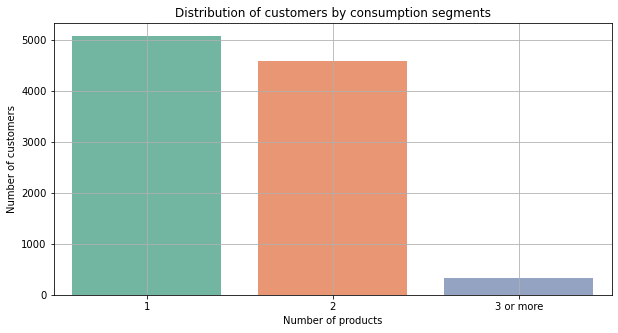

In [31]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='index', y='products_category', data=bank['products_category'].value_counts().reset_index())
ax.set_title('Distribution of customers by consumption segments')
ax.set_xlabel('Number of products')
ax.set_ylabel('Number of customers')
plt.grid()
plt.show()

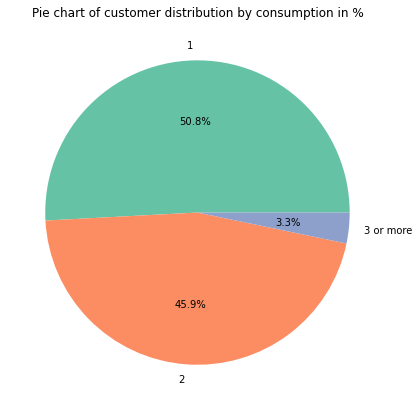

In [32]:
values = bank['products_category'].value_counts().reset_index()['products_category']
labels = bank['products_category'].value_counts().reset_index()['index']
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Pie chart of customer distribution by consumption in %')
plt.show()

Let's see how the features are distributed inside each category. To do this, we will build graphs. For continuous values, we will build histograms, and for discrete ones, countplots:

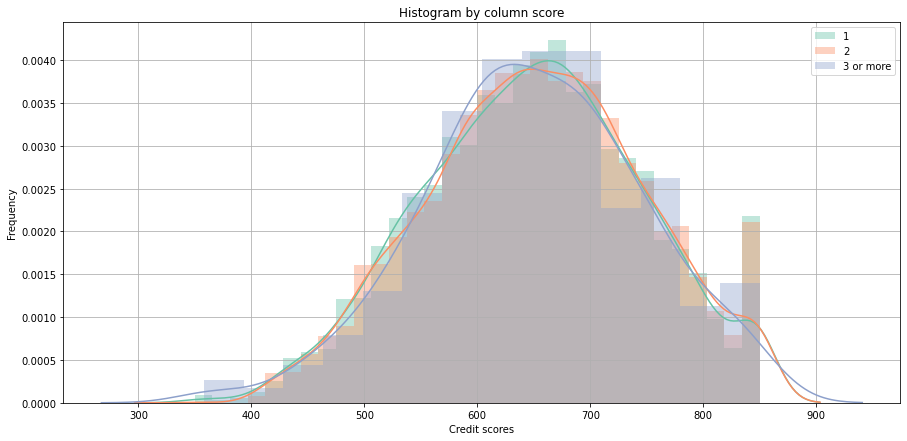

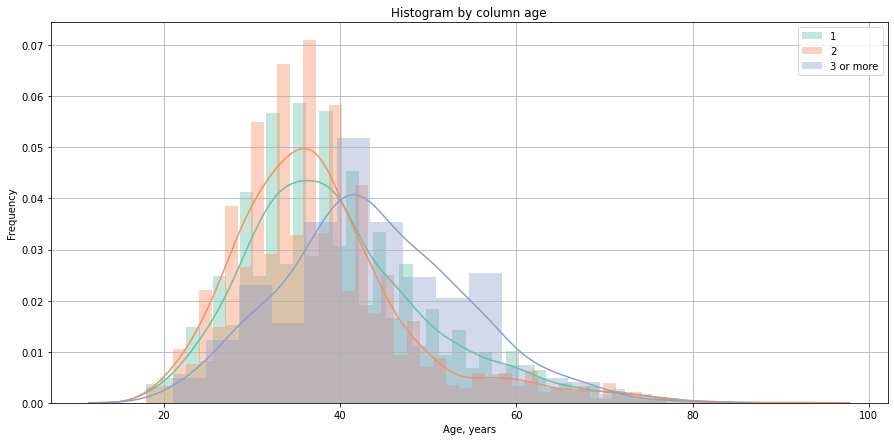

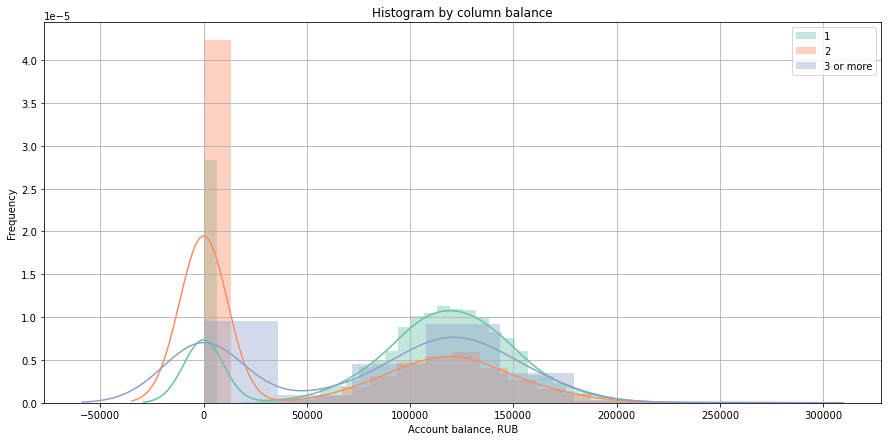

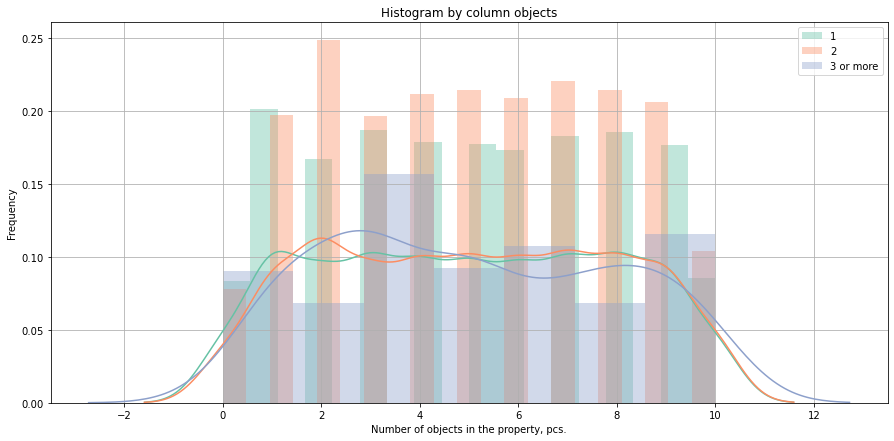

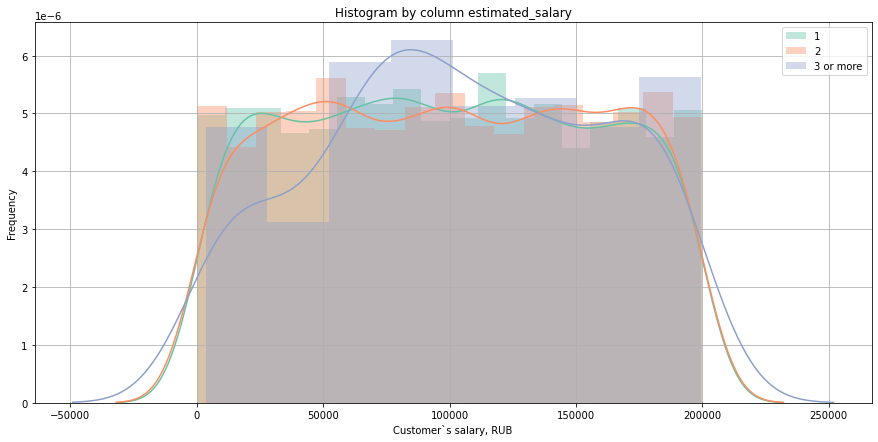

In [33]:
dict_of_col = {'score': 'Credit scores',
               'age': 'Age, years',
               'balance': 'Account balance, RUB',
               'objects': 'Number of objects in the property, pcs.',
               'estimated_salary': 'Customer`s salary, RUB'
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(15, 7))
    ax1 = sns.distplot(bank[bank['products_category'] == '1'][col], label='1')
    ax2 = sns.distplot(bank[bank['products_category'] == '2'][col], label='2')
    ax3 = sns.distplot(bank[bank['products_category'] == '3 or more'][col], label='3 or more')
    ax1.set_title('Histogram by column ' + col)
    ax1.set_xlabel(dict_of_col[col])
    ax1.set_ylabel('Frequency')
    ax1.legend(loc = 'upper right')
    ax2.legend(loc = 'upper right')
    ax3.legend(loc = 'upper right')
    plt.grid()
    plt.show()

The distribution of credit scoring points and the number of properties owned by different categories is almost the same. The age distribution confirms the earlier conclusion that customers who use 3 or more products are older than others. The histogram of the account balance shows that customers with 2 products have the least money, and customers with one product have the most money. The salary histogram shows that customers with 1 and 2 products have approximately the same salary level, while customers with 3 or more products have higher salaries.

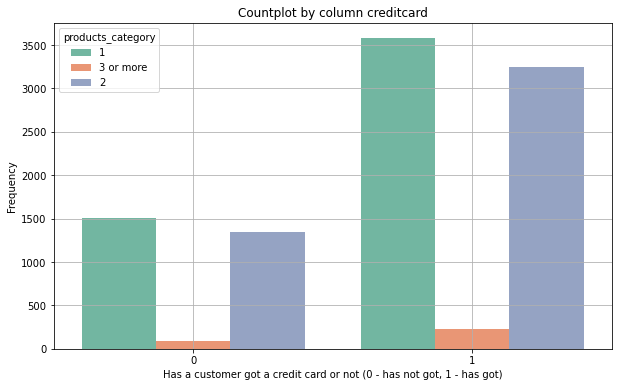

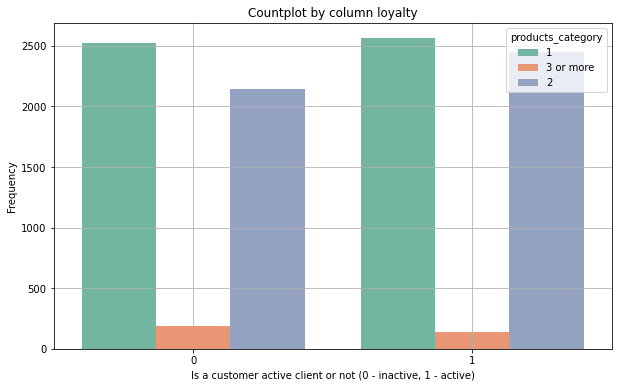

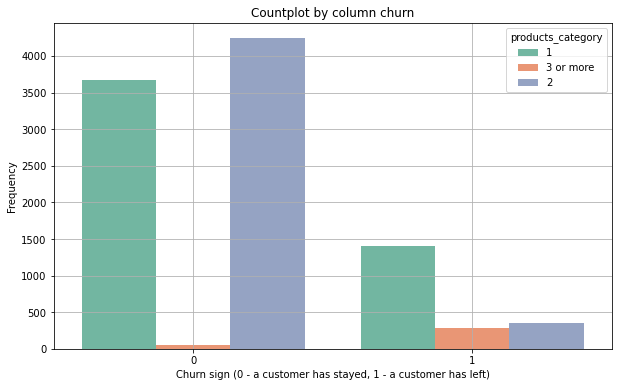

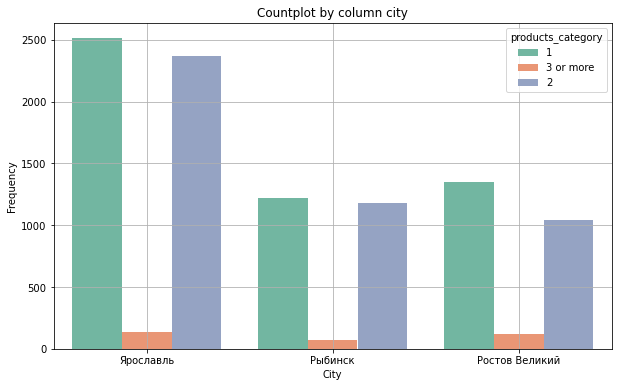

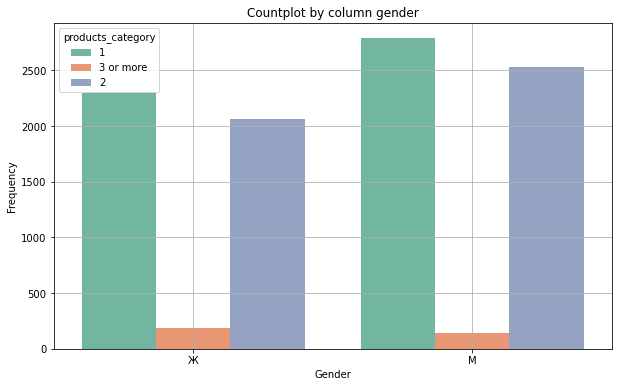

In [34]:
dict_of_col_d = {'creditcard': 'Has a customer got a credit card or not (0 - has not got, 1 - has got)',
                 'loyalty': 'Is a customer active client or not (0 - inactive, 1 - active)',
                 'churn': 'Churn sign (0 - a customer has stayed, 1 - a customer has left)',
                 'city': 'City',
                 'gender': 'Gender'
                }

for col in dict_of_col_d.keys():
    plt.figure(figsize=(10, 6))
    sns.countplot(x = bank[col], hue='products_category', data=bank)
    plt.title('Countplot by column ' + col)
    plt.xlabel(dict_of_col_d[col])
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

The distribution of customers by category in the groups of customers who have a credit card and those who do not have it is almost the same. There are approximately equal numbers of active and inactive clients with one banking product, while in the category of clients with 2 products, the number of active clients is noticeably higher, and in the category of "3 or more", on the contrary, there are more inactive ones. Clients with 2 products churn very little, clients with one product churn more. The highest churn rate is seen among customers with 3 or more products. The smallest number of customers with 3 or more products lives in Rybinsk, but visually it is clear that their percentage with other categories is very similar to the distribution of customers by category in Yaroslavl. In Rostov Veliky, the picture is slightly different - the number of customers who have 3 or more products the same as in Yaroslavl, while Yaroslavl has 2 times more customers than in Rostov Veliky. The gender distribution shows that there are more women than men with 3 or more products, while there are more men than women in the whole sample.

Let's display a table with the average and median values of the parameters for each category:

In [35]:
print('Average parameter values by category')
bank[['score', 'age', 'objects', 'balance',
       'products_category', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].groupby('products_category').mean().T

Average parameter values by category


products_category,1,2,3 or more
score,649.121,652.189,649.113
age,39.673,37.754,43.653
objects,4.975,5.052,5.058
balance,98551.871,51879.146,78821.790
creditcard,0.704,0.707,0.709
loyalty,0.504,0.533,0.436
estimated_salary,99487.257,100452.013,104400.142
churn,0.277,0.076,0.859


In [36]:
print('Median parameter values by category')
bank[['score', 'age', 'objects', 'balance',
       'products_category', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].groupby('products_category').median().T

Median parameter values by category


products_category,1,2,3 or more
score,651.000,653.000,650.000
age,38.000,36.000,43.000
objects,5.000,5.000,5.000
balance,111886.035,0.000,101628.675
creditcard,1.000,1.000,1.000
loyalty,1.000,1.000,0.000
estimated_salary,99226.830,100738.855,103874.670
churn,0.000,0.000,1.000


**Conclusion**

We have segmented customers by the number of used banking products into three categories (1, 2, 3 or more), so now we can to describe the portraits of customers from each category.

Clients with 1 banking product:
- have an average credit rating of 649;
- most of them live in Yaroslavl, then comes Rostov Veliky, and in last place is Rybinsk;
- there are more men among them than women;
- their average age is 39;
- they own an average of 5 properties;
- have on average the highest account balances compared to customers from other categories;
- 70% of them use a credit card;
- half of them are active clients;
- their average salary is approximately 99 000 RUB;
- churn with average intensity (percentage of churn is 27.7).

Clients with 2 banking products:
- have an average credit rating of 652;
- most of them live in Yaroslavl, then comes Rybinsk, then - Rostov Veliky;
- there are more men than women;
- their average age is 37;
- have an average of 5 objects in the property;
- have on average the lowest account balances compared to customers from other categories. About half of the customers do not have an account (balance = 0);
- 70% of them use a credit card;
- slightly more than half of them are active clients;
- the average salary is approximately 100 000 RUB;
- have the least churn part (only 7.6% left).

Clients with 3 or more banking products:
- have an average credit rating of 649;
- almost the same number of clients live in Yaroslavl and Rostov Veliky, in Rybinsk there are in 2 times less than in Yaroslavl;
- there are more women than men;
- average age - 43 years;
- have an average of 5 objects in the property;
- 70% use a credit card;
- less than half of them are active users;
- the average salary is the highest than that of clients from other categories. It is 104 000 RUB;
- churn with high intensity (85.9% gone).

## Tests of hypotheses

Let's start by calculating the salary variances of two samples - customers with one banking product and customers with two banking products. Since we are dealing not with the general population of all clients, but with a sample, to calculate the variance, we will add the parameter `ddof=1` to the `.var()` method.

In [37]:
print('Variance by column "estimated_salary" for customers with one banking product:', 
      np.var(bank[bank['products_category'] == '1']['estimated_salary'], ddof=1))

print('Variance by column "estimated_salary" for customers with two banking products:', 
      np.var(bank[bank['products_category'] == '2']['estimated_salary'], ddof=1))

Variance by column "estimated_salary" for customers with one banking product: 3290585635.08814
Variance by column "estimated_salary" for customers with two banking products: 3339776562.8109965


Let's build the salary distributions of customers with one and two products:

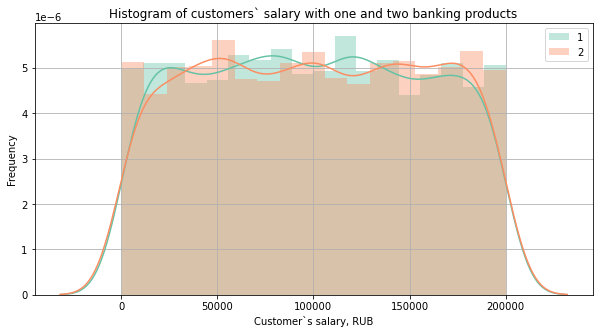

In [38]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(bank[bank['products_category'] == '1']['estimated_salary'], label='1')
ax2 = sns.distplot(bank[bank['products_category'] == '2']['estimated_salary'], label='2')
ax1.set_title('Histogram of customers` salary with one and two banking products')
ax1.set_xlabel('Customer`s salary, RUB')
ax1.set_ylabel('Frequency')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.grid()
plt.show()

Let's test the salary difference hypothesis between those customers who use two bank products and those who use one. Let's start with the formulation of the null hypothesis. Since the null hypothesis is always formulated in such a way as to use the equal sign, in our case it sounds like this:

*The average income of clients with one bank product and the average income of clients with two products do not differ*

We formulate an alternative hypothesis for such a null hypothesis as:

*The average income of clients with one bank product and the average income of clients with two products differ*

Since we are testing the equality of the means of two independent populations from their samples, we use the `.ttest_ind()` method from the `scipy` library to test the hypothesis, applying it to the `estimated_salary` column. From the previous step, we saw that the revenue variances of both samples are close in value, and the sample sizes differ by no more than 10%, so we will not specify the `equal_var` parameter when calling the method (then it will take the default value - True). Let's set a critical level of statistical significance of 5%.

In [39]:
alpha = 0.05  # a critical level of statistical significance

results = st.ttest_ind(
    bank[bank['products_category'] == '1']['estimated_salary'],
    bank[bank['products_category'] == '2']['estimated_salary'])

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Rejecting the null hypothesis')
else:
    print('Failed to reject the null hypothesis')

p-value: 0.41047183624949335
Failed to reject the null hypothesis


We see that the pvalue is much more than 5%, so we do not reject the null hypothesis. The average income of customers with one bank product and the average income of customers with two products do not differ.<br><br>

Let's test the hypothesis of the difference in account balances for customers from Yaroslavl and customers from other cities.

Null hypothesis: *Average account balances of clients from Yaroslavl and clients from other cities do not differ*

Alternative hypothesis: *Average account balances of clients from Yaroslavl and clients from other cities differ*

First, we calculate the variance, sample sizes, and plot the distributions:

In [40]:
print('Variance by the column "balance" for customers from Yaroslavl:', 
      np.var(bank[bank['city'] == 'Ярославль']['balance'], ddof=1))

print('Variance by the column "balance" for customers not from Yaroslavl:', 
      np.var(bank[bank['city'] != 'Ярославль']['balance'], ddof=1))

Variance by the column "balance" for customers from Yaroslavl: 4113114226.882116
Variance by the column "balance" for customers not from Yaroslavl: 3255393298.956701


In [41]:
print('Number of clients from Yaroslavl:', 
      bank[bank['city'] == 'Ярославль']['userid'].count())

print('Number of clients from other cities:', 
      bank[bank['city'] != 'Ярославль']['userid'].count())

Number of clients from Yaroslavl: 5014
Number of clients from other cities: 4986


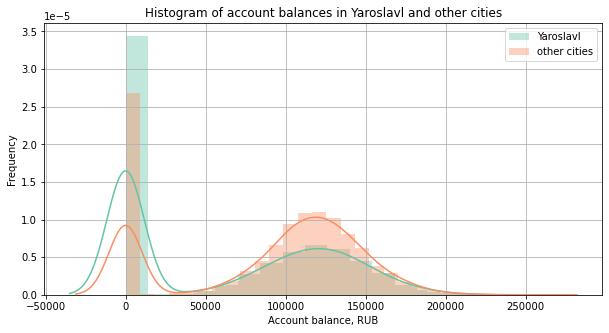

In [42]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(bank[bank['city'] == 'Ярославль']['balance'], label='Yaroslavl')
ax2 = sns.distplot(bank[bank['city'] != 'Ярославль']['balance'], label='other cities')
ax1.set_title('Histogram of account balances in Yaroslavl and other cities')
ax1.set_xlabel('Account balance, RUB')
ax1.set_ylabel('Frequency')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.grid()
plt.show()

The sample sizes are about the same, but the variances are different, so let's pass `equal_var = False` to the method:

In [43]:
results = st.ttest_ind(
    bank[bank['city'] == 'Ярославль']['balance'],
    bank[bank['city'] != 'Ярославль']['balance'],
    equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Rejecting the null hypothesis')
else:
    print('Failed to reject the null hypothesis') 

p-value: 1.2523498173777572e-121
Rejecting the null hypothesis


We see that the pvalue is very close to zero, and we reject the null hypothesis. This means that we do not reject the alternative hypothesis that the average account balances of clients from Yaroslavl and clients from other cities differ.

Let's test the same hypothesis, but excluding outliers at the value of 0 in the balance field from the sample. We will also plot the histograms.

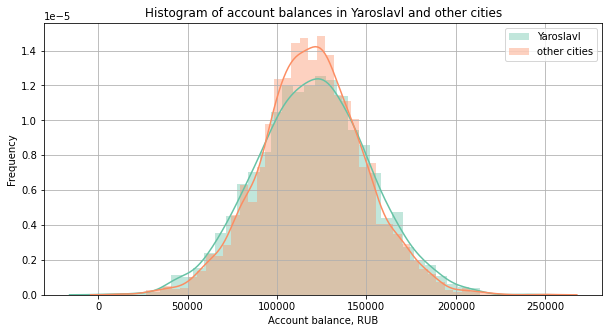

In [44]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(bank[(bank['city'] == 'Ярославль') & (bank['balance'] != 0)]['balance'], label='Yaroslavl')
ax2 = sns.distplot(bank[(bank['city'] != 'Ярославль') & (bank['balance'] != 0)]['balance'], label='other cities')
ax1.set_title('Histogram of account balances in Yaroslavl and other cities')
ax1.set_xlabel('Account balance, RUB')
ax1.set_ylabel('Frequency')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.grid()
plt.show()

In [45]:
results = st.ttest_ind(
    bank[(bank['city'] == 'Ярославль') & (bank['balance'] != 0)]['balance'],
    bank[(bank['city'] != 'Ярославль') & (bank['balance'] != 0)]['balance'],
    equal_var = False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Rejecting the null hypothesis')
else:
    print('Failed to reject the null hypothesis') 

p-value: 0.8285222117901233
Failed to reject the null hypothesis


Testing the hypothesis on a sample without outliers showed the opposite result, that is, the average values of account balances in Yaroslavl and in other cities, excluding customers who do not have a debit card or account, do not differ.

**Conclusion**

The average income of customers with one bank product and the average income of customers with two products do not differ. The hypothesis about the difference in average account balances was tested in two versions: taking into account customers who do not have a debit card, and without taking them into account. It turned out that if we take into account clients without account balances, then the average values of balances for the two samples differ. And if such clients are not taken into account, then the balances on the accounts of clients from Yaroslavl and clients from other cities do not differ.

## Conclusions & recommendations

**Conclusions**

Here we have identified the following patterns: most customers use one or two products; there are 16% more men in the sample than women; active and inactive clients are approximately equal in the sample; about 70% of customers use credit cards; approximately 20% of customers churned.

Next, we segmented customers by the number of products consumed and identified 3 segments: customers who use one banking product, customers who use two banking products and customers who use 3 or more banking products. After analyzing the data in the context of segments, we described the portraits of users in each segment. A detailed description of user portraits is given in the conclusion to step 4.

We also tested two hypotheses: the hypothesis of the difference in average income between those customers who use two bank products and those who use one, and the hypothesis of the difference in average balances on the accounts of customers from Yaroslavl and customers from other cities. The average income of clients with one bank product and the income of clients with two products does not differ. The hypothesis about the difference in average account balances was tested in two versions: taking into account customers who do not have a debit card, and without taking into account. It turned out that if we take into account clients without account balances, then the average values of balances for the two samples differ. And if such clients are not taken into account, then the balances on the accounts of clients from Yaroslavl and clients from other cities do not differ.

**Recommendations**

When compiling user portraits, the following churn pattern emerged: customers with 3 and 4 products churn at a high rate. At the same time, they have on average the highest salary among other segments. From these data, it can be assumed that the bank, seeing the high income of the client, seeks to offer him as many banking products as possible. However, usually people with higher incomes are also more busy (they value their time), and such offers from bank employees are regarded as intrusive, so they churn. Therefore, it is necessary to retain customers not by the number of products, but by certain privileges, for example, increased cashback when spending from a debit card above a certain amount, discounts on investment account rates, etc.

You should also pay attention to customers with one banking product, as consumers from this segment churn although not with such a high, but still with a noticeable intensity. From the description of such users, it can be seen that despite the lowest average salary compared to other segments, these customers have on average the highest debit account balances. Using just one product of the bank, it is quite easy for a client to go to a competitor if he offers any more favorable conditions. Therefore, it is important for clients with one product to offer other products of the bank, taking into account their income and savings. For this segment, the offer of savings and investment accounts may be relevant. Cashback privileges for high account balances can also be effective in retaining customers.

About half of the customers in the two-product user segment do not have an account. At the same time, they are the least prone to churn. Such customers can be attracted to the opening of debit cards, outlining the obvious advantages of the card, for example, the same cashback or the convenience of a mobile application. Keeping in mind that the youngest clients are concentrated in this segment, they may be interested in a mortgage offer. It is also possible to offer lower mortgage interest for debit card holders.